## Brazilian e-commerce dataset by Olist

### Import all stuff

In [305]:
from collections import defaultdict
from functools import partial
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# %matplotlib inline

### Load the data

In [306]:
# Dataset:
# https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
DATASET_DIR = '../../olist_ecommerce_dataset/'
# customer_unique_id not needed (it's interchangeable with order id)
# order_item_id not needed

o_customers = pd.read_csv(f'{DATASET_DIR}olist_customers_dataset.csv')
print(o_customers.columns)
# o_geolocation = pd.read_csv(f'{DATASET_DIR}olist_geolocation_dataset.csv')
# print(o_geolocation.columns)
# order_item_id not needed
o_order_items = pd.read_csv(f'{DATASET_DIR}olist_order_items_dataset.csv')
print(o_order_items.columns)
# o_order_payments = pd.read_csv(f'{DATASET_DIR}olist_order_payments_dataset.csv')
# print(o_order_payments.columns)
# o_order_reviews = pd.read_csv(f'{DATASET_DIR}olist_order_reviews_dataset.csv')
# print(o_order_reviews.columns)
o_customers = pd.read_csv(f'{DATASET_DIR}olist_customers_dataset.csv')
print(o_customers.columns)
# o_category_name_translations = pd.read_csv(f'{DATASET_DIR}product_category_name_translation.csv')
# print(o_category_name_translations.columns)
o_sellers = pd.read_csv(f'{DATASET_DIR}olist_sellers_dataset.csv')
print(o_sellers.columns)
o_products = pd.read_csv(f'{DATASET_DIR}olist_products_dataset.csv')
print(o_products.columns)
o_orders = pd.read_csv(f'{DATASET_DIR}olist_orders_dataset.csv')
print(o_orders.columns)

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')
Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')
Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')
Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')
Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')


### Table of contents for the report

1. Dataset introduction
2. Dataset unnecessary columns
3. Dataset attacks and their requirements:

   - seller identification: location, income, name from business registry - but probably legal name is already shown in store, so wouldn't gain much, except for income knowledge
   - customer identification: approx location, money spent
   - If not enough diversity, some customers are identifiable just by knowing what they bought and in what time window (time window presicion required depends on the diversity of zip codes)
   - product identification (this also makes seller id trivial and cust id much easier)
   - reviews are a privacy nightmare (trivial correlation just by looking at reviews in store)
   - review correlation + customer location + sparse population around ZIP code = resonably precise knowledge where a person lives + (maybe) their name (depends if shown in store) + how much paid for products + when bought/delivered

4. What attributes/outputs should be anonymized/protected:

   - exact product price
   - zip codes of customers and (maybe) sellers
   - income of sellers
   - exact purchase/delivery dates
   - person (when calculating income as a whole for some time period)
   - order (same as above)
   - exact product characteristics
   - must note in each place how anonymization affects utility of the dataset (i. e. what characterisitics we can no longer use/infer) and/or quantify changes

5. Noisy income of sellers (DP):

   - for a query system (i. e. dataset not shared)
   - privacy unit: one item purchase
   - add noise after sum
   - add noise to each purchase - for this maybe share dataset (note that this is not DP)

6. Noisy total income for some fixed time period (e. g. month) (DP):

   - for a query system
   - privacy unit: order
   - privacy unit: customer
   - privacy unit: seller

7. Noisy product characteristics (not DP):

   - goal: make product harder to corelate with the shop
   - noisy dimensions (purpose: limit usefulness of outside knowledge)
   - noisy weight (purpose: same)
   - noisy description metadata (purpose: same)
   - price also, but this is adressed elsewhere because price is unique (but not necesarily different) for each order

8. Generalized/noisy customer ZIP code:

   - show pre and post k values
   - l-diversity - that's about sensitive columns; unclear which ones in this dataset (price?)
   - t-closeness (same as above)?
   - achieve desired k-anonymity
   - use granularity (i. e. only where needed to get higher k), compare results with lower granularity
   - maybe also for a certain time frame? (careful with this, either customer IDs need to be changed, or the same anonymization applied to all time frames, to limit correlation)
   - limit use of outside knowledge
   - noise: amount inversely proportional to ZIP concentration? (look if the paper mentions this; we should not invent our own mechanisms)
   - show how far (distance in km) from true data the processed values are
   - swapping ZIPs between customers?

9. Rounded/noisy prices:

   - for products
   - for freight values
   - suppression/clipping?

10. Generalized/noisy purchase/delivery dates:

   - achieve k-anonymity
   - use granularity? (maybe only if needed after generalising to hour/day)

TODO: privacy metrics for noise? (or can just note and - best - quantify how much privacy it gives, e. g. how many more stuff is similar after the anonymization)

In [127]:
# Post RAndomisation Method (PRAM):
# - section 5.2.6 in article
# - apply to:
#   - order-customer combination - would destroy location-(product/delivery time) analytics
#   - or customer-zipcode combination - same (or very similar) as above
#   - use zip codes to create the transition matrix
# - to minimize distortion:
#   - transition matrix should closely match tistribution of zip codes
#   - can compare naive and optimized versions (e. g. python and rust)
# - maybe just use swapping for this, will give similar results and is much simpler

# Swapping (5.2.1):
# - apply to prices?
# - use rank-swapping

# Microaggregation? (5.2.4) (averaging over a few records, similar to k-anonimity but
# for numerical values)

# - apply a modern (todo: find) method of location protection?
# - look at ways to evaluate usefulness from professors paper (privacy metrics)
# - look for relevant libs

# maybe swap products between vendors:
# - harder to identify sellers
# - majorly reduces delivery data usefulness
# - opportunity: quantify how far from their real locations products become

# report:
# - xy diagrama atstumui nuo tikro dest/src (swapinant orders tarp klientų / swapinant produktus tarp tiekėjų) ir nuo tikros kainos?

# compare performance using pandas/polars?
# if performance is bad somewhere

### Utility functions

In [274]:
def is_k_anonymous(k, qis, df):
    """Returns true if df satisfies k-Anonymity for the quasi-identifiers 
    qis. Returns false otherwise."""
    group_sizes = df.groupby(qis).size()
    for group_size in group_sizes:
        if group_size < k:
            return False
    return True

def suppress(k, qis, df):
    # Suppress rows to achieve k-anonimity
    # We need to remove all groups that have less than k members.
    return df.groupby(qis).filter(lambda g: len(g) >= k)

# l-diversity?

# For counting queries
def laplace_mech(v, sensitivity, epsilon):
    b = sensitivity/epsilon

    # location = mu + v = v for DP
    # scale = b
    return np.random.laplace(v, b)

# def normal_noise(v):
#     # TODO: what stdev to use?
#     # This is not for DP, so unclear. Also not mentioned in paper.
#     # Maybe just say that sensitivity is e. g. 10 for descriptions and 5 for titles?
#     return np.random.normal(v, 5)

# contingecy (category count) table? (h2)

def dp_noisy_clipped_sum(arr, epsilon):
    # Since our goal is to be reasonably accurate with larger datasets, we
    # use up only small amount of privacy budget for this.
    noisy_total_line_count = laplace_mech(len(arr), 1, 0.1 * epsilon)
    epsilon *= 0.9
    cap = 0
    c = 100
    for _ in range(20):
        # get noisy count of lines that fall under the current clip threshold
        count = sum(v <= c for v in arr)
        noisy_count = laplace_mech(count, 1, 0.1 * epsilon)
        epsilon *= 0.8
        if noisy_count >= 0.9 * noisy_total_line_count:
            cap = c
            break;
        c *= 5

    s = sum(min(v, cap) for v in arr)
    # Clipping parameter is the same as sensitivity.
    # Because that't the largest single value possible.
    return laplace_mech(s, cap, epsilon) #remaining_privacy_budget)

# sensitivity

# randomized response: for what? only works for categorical vars


def histogram(df_columns, title, xlabel, ylabel="Number of occurences", bins=50):
    df_columns.hist(bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Number of occurences')
    plt.yscale("log")
    plt.show()

def clip_col(df_col, clip_val):
    return df_col.apply(lambda v: min(v, clip_val))

def buckets(df_col, bucket_size):
    return df_col.apply(lambda v: int(int(v) / bucket_size + 1))

def clip_buckets(df_col, clip_val, bucket_size, clip_low=0):
    return df_col.apply(lambda v: int(int(min(max(v, clip_low), clip_val)) / bucket_size + 1))

In [244]:
# Section 5 (income of sellers)

# Query sys, needs fixing dp_sum_capgain

# Get noisy incomes of all sellers
# plot diff noisy to real sum
# privacy unit: item sale
sellers_item_prices = defaultdict(list)
o_order_items.apply(lambda v: sellers_item_prices[v.seller_id].append(v.price), axis=1)
# print(sellers_item_prices)

# Calculate noisy sums; privacy unit: item purchase
# For each seller, get the true sum and the noisy sum. Will plot their diff.
epsilon = 1
diff_percents = [[], [], [], [], [], [], [], [], [], [], [], []]
vals = list(sellers_item_prices.values())
for i in range(12):
    for item_prices in vals:
        true_sum = sum(item_prices)
        noisy_sum = dp_noisy_clipped_sum(item_prices, epsilon=epsilon)
        diff_percents[i].append(abs(((true_sum - noisy_sum)/true_sum) * 100))
    epsilon *= 2

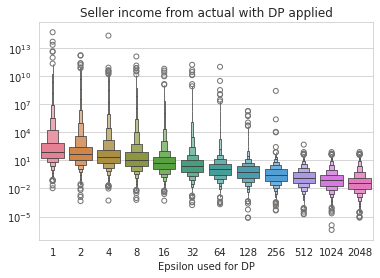

In [252]:
# use letter value plot (aka boxenplot)
# print(diff_percents)
g = sns.boxenplot(diff_percents)
g.set_xticks(range(len(diff_percents)))
g.set_xticklabels([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048])
plt.yscale("log")
plt.title("Seller income from actual with DP applied")
plt.xlabel("Epsilon used for DP")
plt.show()

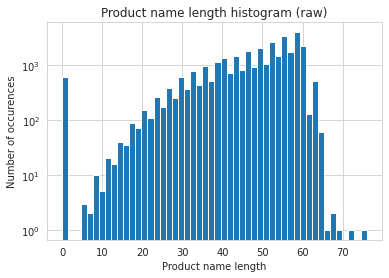

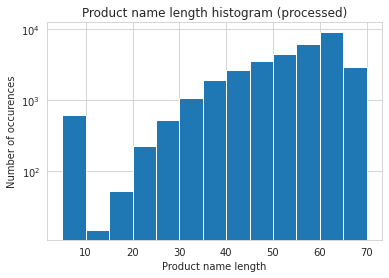

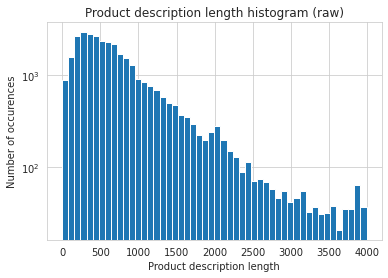

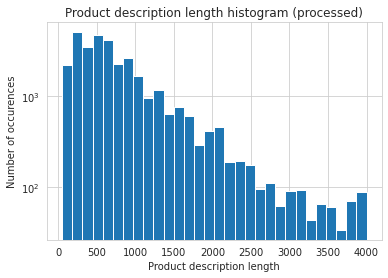

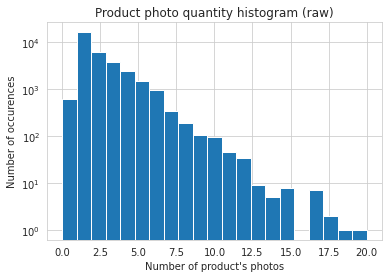

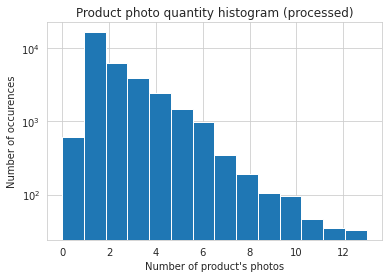

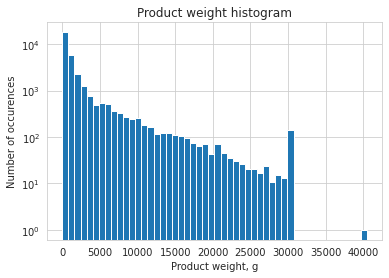

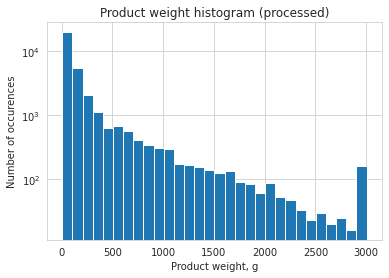

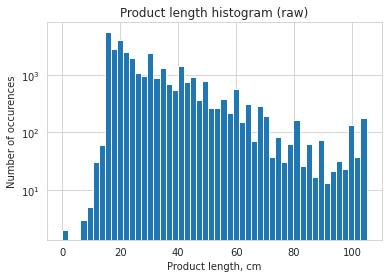

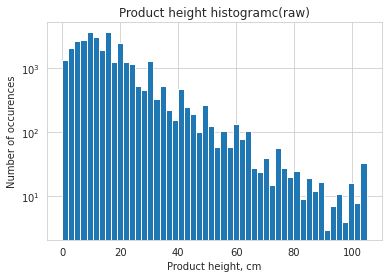

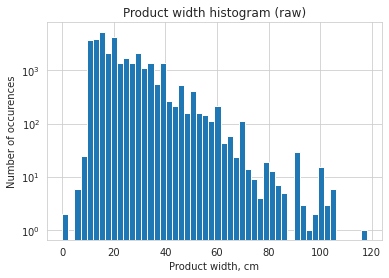

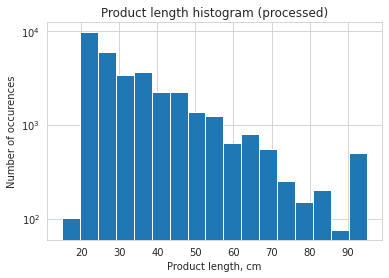

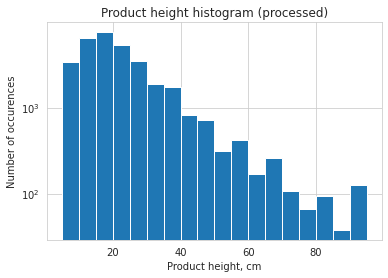

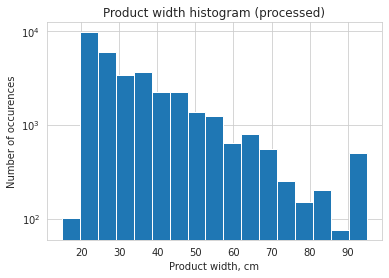

In [272]:
# Section 7 (product characteristics)
o_products_proc = pd.DataFrame()

# Replace NaNs with 0s
o_products.fillna(0, inplace=True)
# Note that NaNs replaced with 0s

# print(o_products.columns)

histogram(o_products[["product_name_lenght"]], "Product name length histogram (raw)", xlabel="Product name length")

# Product name length
# Rounding/bucketization/generalization
# Clip at 65.
# Use buckets. Bucket size 5.
processed_product_name_lengths = clip_buckets(o_products["product_name_lenght"], 65, 5)
o_products_proc.insert(0, "product_name_length", processed_product_name_lengths)
histogram(o_products_proc[["product_name_length"]] * 5, "Product name length histogram (processed)", xlabel="Product name length", bins=13)

# Product description length
histogram(o_products[["product_description_lenght"]], "Product description length histogram (raw)", xlabel="Product description length")
# Use buckets. Bucket size 10.
processed_product_desc_lengths = clip_buckets(o_products["product_description_lenght"], 4000, 50)
o_products_proc.insert(1, "product_desc_length", processed_product_desc_lengths)
histogram(o_products_proc[["product_desc_length"]] * 50, "Product description length histogram (processed)", xlabel="Product description length", bins=30)

# Product photos quantity
histogram(o_products[["product_photos_qty"]], "Product photo quantity histogram (raw)", xlabel="Number of product's photos", bins=21)
# Clip photo number at 13.
# Could use bucketization or add noise, but that would skew the distribution very much;
# most products have 0 or 1 photo.
o_products_proc.insert(2, "product_photos_qty", clip_col(o_products["product_photos_qty"], 13))
histogram(o_products_proc[["product_photos_qty"]], "Product photo quantity histogram (processed)", xlabel="Number of product's photos", bins=14)

# Product weight grams
histogram(o_products[["product_weight_g"]], "Product weight histogram", xlabel="Product weight, g")
# Clip at 30000, bucket size 50
proc_weight = clip_buckets(o_products["product_weight_g"], 30000, 50)
o_products_proc.insert(3, "product_weight_g", proc_weight)
histogram(o_products_proc[["product_weight_g"]] * 5, "Product weight histogram (processed)", xlabel="Product weight, g", bins=30)

# Product dimensions
histogram(o_products[["product_length_cm"]], "Product length histogram (raw)", xlabel="Product length, cm")
histogram(o_products[["product_height_cm"]], "Product height histogramc(raw)", xlabel="Product height, cm")
histogram(o_products[["product_width_cm"]], "Product width histogram (raw)", xlabel="Product width, cm")

# Clip dimensions to [10, 90], bucket size 5.
proc_length = clip_buckets(o_products["product_length_cm"], 90, 5, 10)
o_products_proc.insert(4, "product_length_cm", proc_length)
histogram(o_products_proc[["product_length_cm"]] * 5, "Product length histogram (processed)", xlabel="Product length, cm", bins=int(85 / 5))

proc_height = clip_buckets(o_products["product_height_cm"], 90, 5)
o_products_proc.insert(5, "product_height_cm", proc_height)
histogram(o_products_proc[["product_height_cm"]] * 5, "Product height histogram (processed)", xlabel="Product height, cm", bins=int(90 / 5))

proc_width = clip_buckets(o_products["product_width_cm"], 90, 5, 10)
o_products_proc.insert(6, "product_width_cm", proc_length)
histogram(o_products_proc[["product_width_cm"]] * 5, "Product width histogram (processed)", xlabel="Product width, cm", bins=int(85 / 5))

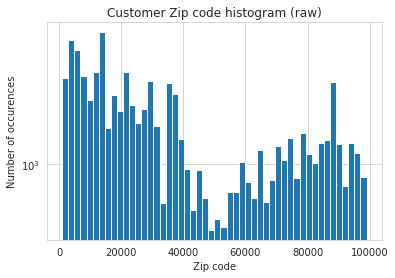

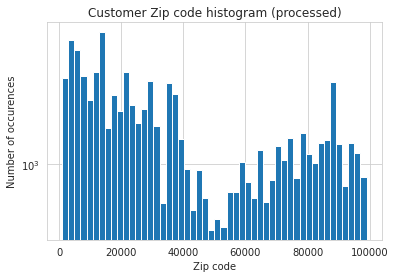

In [319]:
# Section 8 (customer ZIP code)
# print(o_customers.columns)

# For ints only
def generalize_numeric(val, most_significant_digits):
    return int(val / 10**most_significant_digits) * 10**most_significant_digits

for k in range(1, 20):
    if not is_k_anonymous(k, ["customer_zip_code_prefix"], o_customers):
        break
    # else:
        # print(f"Is {k} anonymous")

# Generalize ZIP code to achieve k = 10
zip_backup = o_customers["customer_zip_code_prefix"]
o_customers["customer_zip_code_prefix"] = o_customers["customer_zip_code_prefix"].apply(lambda z: generalize_numeric(z, 3))
achieved_k = 1
for k in range(1, 100):
    if not is_k_anonymous(k, ["customer_zip_code_prefix"], o_customers):
        achieved_k = k - 1
        break
    # else:
        # print(f"Is {k} anonymous")


# def histogram(df_columns, title, xlabel, ylabel="Number of occurences", bins=50):
#     df_columns.hist(bins=bins)
#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel('Number of occurences')
#     plt.yscale("log")
#     plt.show()

histogram(zip_backup, "Customer Zip code histogram (raw)", xlabel="Zip code", bins=50)
histogram(o_customers["customer_zip_code_prefix"], "Customer Zip code histogram (processed)", xlabel="Zip code", bins=50)


In [ ]:
# Section 9 (product prices)

In [ ]:
# Section 10 (delivery dates)